# This pipeline is for Eric's blood vessel data analysis-- by Qiao Ye, 2024


Data are generated using ImageJ pipeline

## Blood Vessel Area

### Extract data

C:\Users\exx\AppData\Local\Temp\ipykernel_27652\3705123591.py:108: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Combined data saved to Y:\Lab\Qiao_public\dataimages\Qiao\Eric's endothelial project\R1-quantification\Quantification_Results\combined-results.xlsx
Plot saved as Y:\Lab\Qiao_public\dataimages\Qiao\Eric's endothelial project\R1-quantification\Quantification_Results\plot-results.eps


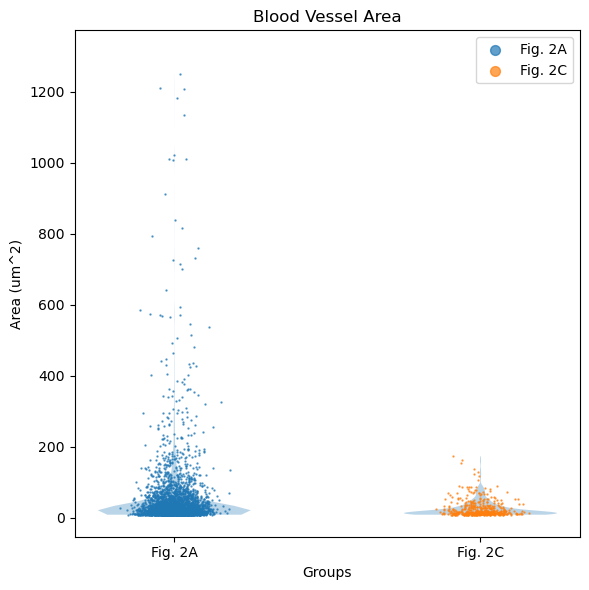

In [8]:
%reset -f

import os
import pandas as pd
import matplotlib.pyplot as plt
import glob
import numpy as np
from matplotlib.legend_handler import HandlerPathCollection

# Specify the folder containing files
folder_path = "Y:\Lab\Qiao_public\dataimages\Qiao\Eric's endothelial project\R1-quantification\Quantification_Results"  # Change this to the correct folder path
output_file = "Y:\Lab\Qiao_public\dataimages\Qiao\Eric's endothelial project\R1-quantification\Quantification_Results\combined-results.xlsx"  # Output file name
output_plot = "Y:\Lab\Qiao_public\dataimages\Qiao\Eric's endothelial project\R1-quantification\Quantification_Results\plot-results.eps"  # Output file name
# Create the output folder if it doesn't exist
os.makedirs(folder_path, exist_ok=True)

# Find all CSV files ending with "-Results.csv" in the folder
file_paths = glob.glob(os.path.join(folder_path, "*_Results.csv"))

# Check if there are valid files to process
if not file_paths:
    print("No valid files found in the specified folder. Please add files and try again.")
else:
    # Initialize a dataframe for combined results
    combined_data = pd.DataFrame(columns=["Source File", "Values"])
    
    # Process each file
    for file_path in file_paths:
        # Get the file name (without extension)
        file_name = os.path.basename(file_path).replace(".csv", "")
        
        # Read the CSV file
        try:
            df = pd.read_csv(file_path)
            second_column = df.iloc[:, 2]  # Extract the second column
            
            # Ensure the column is numeric (ignore invalid rows)
            second_column = pd.to_numeric(second_column, errors='coerce')
            second_column = second_column.dropna()  # Remove invalid rows
            
            # Append data to combined DataFrame
            temp_df = pd.DataFrame({
                "Source File": [file_name] * len(second_column),
                "Values": second_column
            })
            combined_data = pd.concat([combined_data, temp_df], ignore_index=True)
        except Exception as e:
            print(f"Error processing {file_path}: {e}")
    
    # Save combined data to Excel
    combined_data.to_excel(output_file, index=False)
    print(f"Combined data saved to {output_file}")

     # Prepare two groups based on file name criteria
    group_2A = combined_data[combined_data["Source File"].str.contains("Fig2A", na=False)]["Values"].dropna().tolist()
    group_2C = combined_data[combined_data["Source File"].str.contains("Fig2C", na=False)]["Values"].dropna().tolist()
    group_2A = [y * 0.65*0.65 for y in group_2A]
    group_2C = [y * 0.65*0.65 for y in group_2C]
    # Plot violin plot for the two groups
    plt.figure(figsize=(6, 6))

    # Ensure at least one group has valid data
    if group_2A or group_2C:
        # Create the violin plot
        parts = plt.violinplot([group_2A, group_2C], showmeans=False, showextrema=False, showmedians=False)

        # Overlay the raw data points
        x_positions = [1, 2]  # x-positions for the groups
        scatter_plots = []  # To store scatter plots for the legend
        for i, group_data in enumerate([group_2A, group_2C]):
            jittered_x = np.random.normal(x_positions[i], 0.05, size=len(group_data))  # Add jitter
            scatter=plt.scatter(
                jittered_x, 
                group_data, 
                alpha=0.7, 
                s=0.5,  # Marker size (smaller size)
                label=f"Fig. {'2A' if i == 0 else '2C'}" 
            )
            scatter_plots.append(scatter)  # Save scatter for the legend
    

        # Set labels for the groups
        plt.xticks(x_positions, ["Fig. 2A", "Fig. 2C"])

        # Adjust y-axis limits to add padding
        all_values = group_2A + group_2C
        if all_values:  # Only if there is data
            y_min = min(all_values)
            y_max = max(all_values)
            padding = 0.1 * (y_max - y_min)  # Add 10% padding above and below
            plt.ylim(y_min - 0.5*padding, y_max + padding)

        plt.title("Blood Vessel Area")
        plt.ylabel("Area (um^2)")
        plt.xlabel("Groups")
       # plt.grid(axis='y')
        
        plt.legend(
            handles=scatter_plots, 
            handler_map={scatter_plots[0]: HandlerPathCollection(marker_pad=0.3)}, 
            scatterpoints=1,
            markerscale=10,  # Enlarge legend marker size
            loc="upper right"
        )
        plt.tight_layout()
        
         # Save the plot as an EPS file
        plt.tight_layout()
        plt.savefig(output_plot, format='eps')
        print(f"Plot saved as {output_plot}")
        plt.show()
        
    else:
        print("No valid data available for plotting.")


### LME statistical analysis

In [2]:

import pandas as pd
import statsmodels.formula.api as smf

# Combine the data into a single DataFrame
data = pd.DataFrame({
    "Values": group_2A + group_2C,
    "Group": ["Fig. 2A"] * len(group_2A) + ["Fig. 2C"] * len(group_2C),
    "Subject": [f"Subject_{i}" for i in range(len(group_2A))] + [f"Subject_{i}" for i in range(len(group_2C))]
})

# Mixed model: Random intercept for each subject
model = smf.mixedlm("Values ~ Group", data, groups=data["Subject"], re_formula="~1")
result = model.fit()

# Print the summary with detailed p-values
print(result.summary())

# Extract p-values and format with more precision
p_values = result.pvalues
print("\nDetailed P-Values of area:")
for term, pval in p_values.items():
    print(f"{term}: {pval:.10f}")


             Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   Values     
No. Observations:   4393      Method:               REML       
No. Groups:         3887      Scale:                34979.3747 
Min. group size:    1         Log-Likelihood:       -29359.2600
Max. group size:    2         Converged:            Yes        
Mean group size:    1.1                                        
---------------------------------------------------------------
                  Coef.   Std.Err.   z    P>|z|  [0.025  0.975]
---------------------------------------------------------------
Intercept         104.252    3.106 33.569 0.000  98.166 110.339
Group[T.Fig. 2C]  -46.023    9.065 -5.077 0.000 -63.790 -28.257
Group Var        2509.901   13.905                             


Detailed P-Values of area:
Intercept: 0.0000000000
Group[T.Fig. 2C]: 0.0000003830
Group Var: 0.3344826023


## Blood Vessel Branch

### Extract data

Error processing Y:\Lab\Qiao_public\dataimages\Qiao\Eric's endothelial project\R1-quantification\Quantification_Results\Fig2A_M1_slice 4_SSp_1000x500_6.tif (green)_Branch_information.csv: single positional indexer is out-of-bounds
Combined data saved to Y:\Lab\Qiao_public\dataimages\Qiao\Eric's endothelial project\R1-quantification\Quantification_Results\combined-branch.xlsx


C:\Users\exx\AppData\Local\Temp\ipykernel_27652\1875072407.py:107: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Plot saved as Y:\Lab\Qiao_public\dataimages\Qiao\Eric's endothelial project\R1-quantification\Quantification_Results\plot-branch.eps


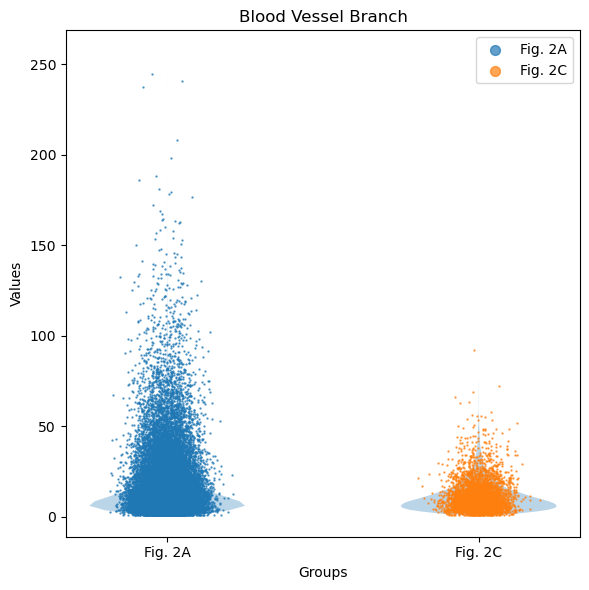

In [3]:
%reset -f

import os
import pandas as pd
import matplotlib.pyplot as plt
import glob
import numpy as np
from matplotlib.legend_handler import HandlerPathCollection

# Specify the folder containing files
folder_path = "Y:\Lab\Qiao_public\dataimages\Qiao\Eric's endothelial project\R1-quantification\Quantification_Results"  # Change this to the correct folder path
output_file = "Y:\Lab\Qiao_public\dataimages\Qiao\Eric's endothelial project\R1-quantification\Quantification_Results\combined-branch.xlsx"  # Output file name
output_plot = "Y:\Lab\Qiao_public\dataimages\Qiao\Eric's endothelial project\R1-quantification\Quantification_Results\plot-branch.eps"  # Output file name
# Create the output folder if it doesn't exist
os.makedirs(folder_path, exist_ok=True)

# Find all CSV files ending with "-Results.csv" in the folder
file_paths = glob.glob(os.path.join(folder_path, "*_Branch_information.csv"))

# Check if there are valid files to process
if not file_paths:
    print("No valid files found in the specified folder. Please add files and try again.")
else:
    # Initialize a dataframe for combined results
    combined_data = pd.DataFrame(columns=["Source File", "Values"])
    
    # Process each file
    for file_path in file_paths:
        # Get the file name (without extension)
        file_name = os.path.basename(file_path).replace(".csv", "")
        
        # Read the CSV file
        try:
            df = pd.read_csv(file_path)
            second_column = df.iloc[:, 1]  # Extract the second column
            
            # Ensure the column is numeric (ignore invalid rows)
            second_column = pd.to_numeric(second_column, errors='coerce')
            second_column = second_column.dropna()  # Remove invalid rows
            
            # Append data to combined DataFrame
            temp_df = pd.DataFrame({
                "Source File": [file_name] * len(second_column),
                "Values": second_column
            })
            combined_data = pd.concat([combined_data, temp_df], ignore_index=True)
        except Exception as e:
            print(f"Error processing {file_path}: {e}")
    
    # Save combined data to Excel
    combined_data.to_excel(output_file, index=False)
    print(f"Combined data saved to {output_file}")

     # Prepare two groups based on file name criteria
    group_2A = combined_data[combined_data["Source File"].str.contains("Fig2A", na=False)]["Values"].dropna().tolist()
    group_2C = combined_data[combined_data["Source File"].str.contains("Fig2C", na=False)]["Values"].dropna().tolist()

    # Plot violin plot for the two groups
    plt.figure(figsize=(6, 6))

    # Ensure at least one group has valid data
    if group_2A or group_2C:
        # Create the violin plot
        parts = plt.violinplot([group_2A, group_2C], showmeans=False, showextrema=False, showmedians=False)

        # Overlay the raw data points
        x_positions = [1, 2]  # x-positions for the groups
        scatter_plots = []  # To store scatter plots for the legend
        for i, group_data in enumerate([group_2A, group_2C]):
            jittered_x = np.random.normal(x_positions[i], 0.05, size=len(group_data))  # Add jitter
            scatter=plt.scatter(
                jittered_x, 
                group_data, 
                alpha=0.7, 
                s=0.5,  # Marker size (smaller size)
                label=f"Fig. {'2A' if i == 0 else '2C'}" 
            )
            scatter_plots.append(scatter)  # Save scatter for the legend
    

        # Set labels for the groups
        plt.xticks(x_positions, ["Fig. 2A", "Fig. 2C"])

        # Adjust y-axis limits to add padding
        all_values = group_2A + group_2C
        if all_values:  # Only if there is data
            y_min = min(all_values)
            y_max = max(all_values)
            padding = 0.1 * (y_max - y_min)  # Add 10% padding above and below
            plt.ylim(y_min - 0.5*padding, y_max + padding)

        plt.title("Blood Vessel Branch")
        plt.ylabel("Branch numbers")
        plt.xlabel("Groups")
       # plt.grid(axis='y')
        
        plt.legend(
            handles=scatter_plots, 
            handler_map={scatter_plots[0]: HandlerPathCollection(marker_pad=0.3)}, 
            scatterpoints=1,
            markerscale=10,  # Enlarge legend marker size
            loc="upper right"
        )
        plt.tight_layout()
        
         # Save the plot as an EPS file
        plt.tight_layout()
        plt.savefig(output_plot, format='eps')
        print(f"Plot saved as {output_plot}")
        plt.show()
        
    else:
        print("No valid data available for plotting.")


### LME statistical analysis

In [4]:

import pandas as pd
import statsmodels.formula.api as smf

# Combine the data into a single DataFrame
data = pd.DataFrame({
    "Values": group_2A + group_2C,
    "Group": ["Fig. 2A"] * len(group_2A) + ["Fig. 2C"] * len(group_2C),
    "Subject": [f"Subject_{i}" for i in range(len(group_2A))] + [f"Subject_{i}" for i in range(len(group_2C))]
})

# Mixed model: Random intercept for each subject
model = smf.mixedlm("Values ~ Group", data, groups=data["Subject"], re_formula="~1")
result = model.fit()

# Print the summary with detailed p-values
print(result.summary())

# Extract p-values and format with more precision
p_values = result.pvalues
print("\nDetailed P-Values of branch:")
for term, pval in p_values.items():
    print(f"{term}: {pval:.10f}")


           Mixed Linear Model Regression Results
Model:              MixedLM Dependent Variable: Values      
No. Observations:   35534   Method:             REML        
No. Groups:         31324   Scale:              272.5593    
Min. group size:    1       Log-Likelihood:     -150074.5589
Max. group size:    2       Converged:          Yes         
Mean group size:    1.1                                     
------------------------------------------------------------
                 Coef.  Std.Err.    z    P>|z| [0.025 0.975]
------------------------------------------------------------
Intercept        16.128    0.093 172.803 0.000 15.945 16.310
Group[T.Fig. 2C] -5.140    0.276 -18.630 0.000 -5.681 -4.599
Group Var         0.281    0.282                            


Detailed P-Values of branch:
Intercept: 0.0000000000
Group[T.Fig. 2C]: 0.0000000000
Group Var: 0.9518115366


## Blood Vessel Distance

### Extract data

C:\Users\exx\AppData\Local\Temp\ipykernel_27652\4152632188.py:108: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Combined data saved to Y:\Lab\Qiao_public\dataimages\Qiao\Eric's endothelial project\R1-quantification\Quantification_Results\combined-distance.xlsx
Plot saved as Y:\Lab\Qiao_public\dataimages\Qiao\Eric's endothelial project\R1-quantification\Quantification_Results\plot-distance.eps


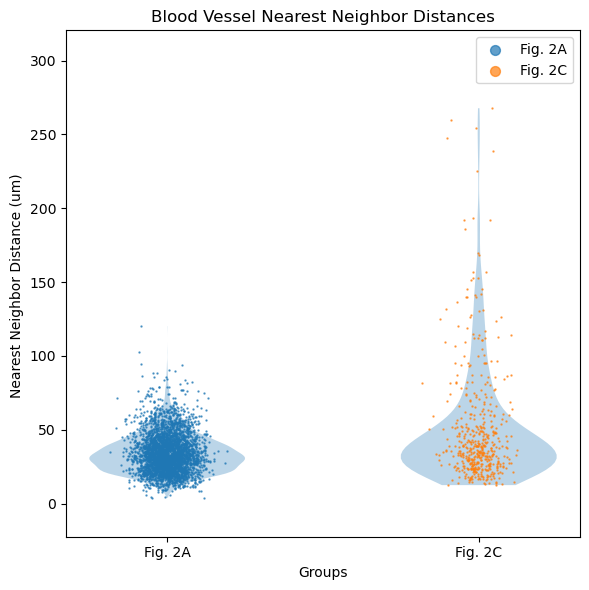

In [9]:
%reset -f

import os
import pandas as pd
import matplotlib.pyplot as plt
import glob
import numpy as np
from matplotlib.legend_handler import HandlerPathCollection

# Specify the folder containing files
folder_path = "Y:\Lab\Qiao_public\dataimages\Qiao\Eric's endothelial project\R1-quantification\Quantification_Results"  # Change this to the correct folder path
output_file = "Y:\Lab\Qiao_public\dataimages\Qiao\Eric's endothelial project\R1-quantification\Quantification_Results\combined-distance.xlsx"  # Output file name
output_plot = "Y:\Lab\Qiao_public\dataimages\Qiao\Eric's endothelial project\R1-quantification\Quantification_Results\plot-distance.eps"  # Output file name
# Create the output folder if it doesn't exist
os.makedirs(folder_path, exist_ok=True)

# Find all CSV files ending with "-Results.csv" in the folder
file_paths = glob.glob(os.path.join(folder_path, "*_Distances.csv"))

# Check if there are valid files to process
if not file_paths:
    print("No valid files found in the specified folder. Please add files and try again.")
else:
    # Initialize a dataframe for combined results
    combined_data = pd.DataFrame(columns=["Source File", "Values"])
    
    # Process each file
    for file_path in file_paths:
        # Get the file name (without extension)
        file_name = os.path.basename(file_path).replace(".csv", "")
        
        # Read the CSV file
        try:
            df = pd.read_csv(file_path)
            second_column = df.iloc[:, 0]  # Extract the second column
            
            # Ensure the column is numeric (ignore invalid rows)
            second_column = pd.to_numeric(second_column, errors='coerce')
            second_column = second_column.dropna()  # Remove invalid rows
            
            # Append data to combined DataFrame
            temp_df = pd.DataFrame({
                "Source File": [file_name] * len(second_column),
                "Values": second_column
            })
            combined_data = pd.concat([combined_data, temp_df], ignore_index=True)
        except Exception as e:
            print(f"Error processing {file_path}: {e}")
    
    # Save combined data to Excel
    combined_data.to_excel(output_file, index=False)
    print(f"Combined data saved to {output_file}")

     # Prepare two groups based on file name criteria
    group_2A = combined_data[combined_data["Source File"].str.contains("Fig2A", na=False)]["Values"].dropna().tolist()
    group_2C = combined_data[combined_data["Source File"].str.contains("Fig2C", na=False)]["Values"].dropna().tolist()
    group_2A = [y * 0.65 for y in group_2A]
    group_2C = [y * 0.65 for y in group_2C]
    # Plot violin plot for the two groups
    plt.figure(figsize=(6, 6))

    # Ensure at least one group has valid data
    if group_2A or group_2C:
        # Create the violin plot
        parts = plt.violinplot([group_2A, group_2C], showmeans=False, showextrema=False, showmedians=False)

        # Overlay the raw data points
        x_positions = [1, 2]  # x-positions for the groups
        scatter_plots = []  # To store scatter plots for the legend
        for i, group_data in enumerate([group_2A, group_2C]):
            jittered_x = np.random.normal(x_positions[i], 0.05, size=len(group_data))  # Add jitter
            scatter=plt.scatter(
                jittered_x, 
                group_data, 
                alpha=0.7, 
                s=0.5,  # Marker size (smaller size)
                label=f"Fig. {'2A' if i == 0 else '2C'}" 
            )
            scatter_plots.append(scatter)  # Save scatter for the legend
    

        # Set labels for the groups
        plt.xticks(x_positions, ["Fig. 2A", "Fig. 2C"])

        # Adjust y-axis limits to add padding
        all_values = group_2A + group_2C
        if all_values:  # Only if there is data
            y_min = min(all_values)
            y_max = max(all_values)
            padding = 0.20 * (y_max - y_min)  # Add 10% padding above and below
            plt.ylim(y_min - 0.5*padding, y_max + padding)

        plt.title("Blood Vessel Nearest Neighbor Distances")
        plt.ylabel("Nearest Neighbor Distance (um) ")
        plt.xlabel("Groups")
       # plt.grid(axis='y')
        
        plt.legend(
            handles=scatter_plots, 
            handler_map={scatter_plots[0]: HandlerPathCollection(marker_pad=0.3)}, 
            scatterpoints=1,
            markerscale=10,  # Enlarge legend marker size
            loc="upper right"
        )
        plt.tight_layout()
        
         # Save the plot as an EPS file
        plt.tight_layout()
        plt.savefig(output_plot, format='eps')
        print(f"Plot saved as {output_plot}")
        plt.show()
        
    else:
        print("No valid data available for plotting.")


### LME statistical analysis

In [6]:

import pandas as pd
import statsmodels.formula.api as smf

# Combine the data into a single DataFrame
data = pd.DataFrame({
    "Values": group_2A + group_2C,
    "Group": ["Fig. 2A"] * len(group_2A) + ["Fig. 2C"] * len(group_2C),
    "Subject": [f"Subject_{i}" for i in range(len(group_2A))] + [f"Subject_{i}" for i in range(len(group_2C))]
})

# Mixed model: Random intercept for each subject
model = smf.mixedlm("Values ~ Group", data, groups=data["Subject"], re_formula="~1")
result = model.fit()

# Print the summary with detailed p-values
print(result.summary())

# Extract p-values and format with more precision
p_values = result.pvalues
print("\nDetailed P-Values of nearest neighbor distances:")
for term, pval in p_values.items():
    print(f"{term}: {pval:.10f}")


           Mixed Linear Model Regression Results
Model:             MixedLM  Dependent Variable:  Values     
No. Observations:  4325     Method:              REML       
No. Groups:        3819     Scale:               787.8561   
Min. group size:   1        Log-Likelihood:      -20576.0533
Max. group size:   2        Converged:           Yes        
Mean group size:   1.1                                      
------------------------------------------------------------
                 Coef.  Std.Err.    z    P>|z| [0.025 0.975]
------------------------------------------------------------
Intercept        52.611    0.456 115.322 0.000 51.716 53.505
Group[T.Fig. 2C] 25.162    1.334  18.868 0.000 22.548 27.775
Group Var         6.970    0.623                            


Detailed P-Values of nearest neighbor distances:
Intercept: 0.0000000000
Group[T.Fig. 2C]: 0.0000000000
Group Var: 0.6899996958
